# <b> <font color='#A20025'> 📚 Chapter 8: Introduction to Deep Learning

*This notebook contains the code examples in chapter 8. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

This chapter marks a segway across several domains. In chapters 1 through 7, we covered a sizeable swath of machine learning methods and how to apply them, typically using Scikit-Learn, to problems in drug discovery with a focus on ligand-based applications. In the second half, we will transition to advanced methods that underly deep learning. To apply these methods, we’ll expand our tool usage to PyTorch, a well-known and popular deep learning framework. Lastly, we’ll increase the scope of our projects to cover structure-based applications, e.g., how a ligand interacts with a known protein structure. 

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH08_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers:
- The kinase protein family from perspectives of both ligand- and structure-based virtual screening (VS)
- An introduction to PyTorch for constructing, training, and evaluating neural networks
- Theory underlying neural networks and common ways to improve their performance

## <b> <font color='#A20025'> ⚙️ Environment Setup

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
CHAPTER = "ch08"
os.makedirs(f"artifacts/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}", exist_ok=True)
os.makedirs(f"figures/{CHAPTER}", exist_ok=True)
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch08/kinase_binder_model.pth" -O "artifacts/ch08/kinase_binder_model.pth"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch08/CH08_EGFR-activities-chembl33.csv" -O "data/ch08/CH08_EGFR-activities-chembl33.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/ml4dd2025.yml" -O "env.yml"

In [ ]:
# Colab users only
!pip install -q condacolab
import condacolab
condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab users only
# Verify condalab installation
import condacolab
condacolab.check()

In [ ]:
# Colab users only
# We can only use the base environment in `condacolab`, so we will update it with the `env.yml` file we downloaded earlier.
!mamba env update -n base -f env.yml

In [ ]:
# Colab users only
# Restart runtime to make packages available
import os
os.kill(os.getpid(), 9)

### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [2]:
# Core data science packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Chemical informatics packages
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold

# Machine learning packages
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve, auc
from sklearn.model_selection import train_test_split

# PyTorch - deep learning framework
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

# Set up logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define any constants
CHAPTER = "ch08"

 ### <b> <font color='#A20025'> Setup Configuration

In [4]:
# Check PyTorch version and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Define the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.4.1+cu121
CUDA available: False
Using device: cpu


In [16]:
# Matplotlib and Seaborn setup for consistent visualizations
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = ["#A20025", "#6C8EBF", "#21130d"]
    sns.set_palette(sns.color_palette(colors))
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['legend.fontsize'] = 16   
    plt.rcParams['xtick.labelsize'] = 16   
    plt.rcParams['ytick.labelsize'] = 16    

setup_visualization_style()
%matplotlib inline

In [6]:
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    """Set random seeds for reproducible results"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_random_seeds()

## <b> <font color='#A20025'> 1️⃣ Ligand-based VS with PyTorch

This section demonstrates how to use PyTorch to build a deep learning model for ligand-based virtual screening. We'll predict binding activities for kinase targets using a neural network.


### <b> <font color='#A20025'> PyTorch Tensor Basics


PyTorch is centered around tensors, which are multi-dimensional arrays similar to NumPy arrays but with additional features for deep learning. Let's explore some basic tensor operations:

In [7]:
tensor_2d = torch.tensor([[1, 2], [3, 4]])
print(f"Two-dimensional tensor: {tensor_2d}")
print(f"Shape of tensor: {tensor_2d.shape}")
print(f"Datatype of tensor: {tensor_2d.dtype}")
print(f"Device tensor is stored on: {tensor_2d.device}")

Two-dimensional tensor: tensor([[1, 2],
        [3, 4]])
Shape of tensor: torch.Size([2, 2])
Datatype of tensor: torch.int64
Device tensor is stored on: cpu


In [8]:
tensor_2d_float = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
print(f"Data type of tensor: {tensor_2d_float.dtype}")
tensor_2d_float = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
print(f"Data type of tensor: {tensor_2d_float.dtype}")

Data type of tensor: torch.float32
Data type of tensor: torch.float32


In [9]:
tensor_2d_float = tensor_2d.to(torch.float32)
print(f"Data type of tensor: {tensor_2d_float.dtype}")

Data type of tensor: torch.float32


In [10]:
tensor_df_mod = tensor_2d + 2
print(f"Modified two-dimensional tensor: {tensor_df_mod}")

Modified two-dimensional tensor: tensor([[3, 4],
        [5, 6]])


In [11]:
tensor_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(f"Reshaped tensor: {tensor_2d.reshape(3, 2)}")
print(f"Original tensor: {tensor_2d}")

Reshaped tensor: tensor([[1, 2],
        [3, 4],
        [5, 6]])
Original tensor: tensor([[1, 2, 3],
        [4, 5, 6]])


In [12]:
tensor_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(f"Reshaped tensor: {tensor_2d.view(3, 2)}")

Reshaped tensor: tensor([[1, 2],
        [3, 4],
        [5, 6]])


In [13]:
print(tensor_2d.T)

tensor([[1, 4],
        [2, 5],
        [3, 6]])


In [14]:
tensor = torch.ones(3, 3)
print(f"Tensor: {tensor}")
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(f"Modified tensor: {tensor}")
t1 = torch.cat([tensor, tensor], dim=1)
print(f"Row-wise concatenation of two tensors: {t1}")

Tensor: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
First row: tensor([1., 1., 1.])
First column: tensor([1., 1., 1.])
Last column: tensor([1., 1., 1.])
Modified tensor: tensor([[1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.]])
Row-wise concatenation of two tensors: tensor([[1., 0., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1.]])


In [15]:
print(tensor_2d.matmul(tensor_2d.T))
print(tensor_2d @ tensor_2d.T)

tensor([[14, 32],
        [32, 77]])
tensor([[14, 32],
        [32, 77]])


### <b> <font color='#A20025'> Loading and Preparing the Kinase Dataset

We'll use EGFR kinase data from ChEMBL to build our model. First, let's load and prepare the dataset:

In [10]:
def load_kinase_data(file_path="data/ch08/CH08_EGFR-activities-chembl33.csv"):
    """
    Load and preprocess the kinase binding data.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file with binding data
        
    Returns:
    --------
    pandas.DataFrame
        Processed dataframe with SMILES and activity values
    """
    try:
        # Load the data
        data = pd.read_csv(file_path)
        
        # Keep only the necessary columns
        data = data[["compound_structures.canonical_smiles", "activities.standard_value"]]
        
        # Rename columns for clarity
        data.columns = ["SMILES", "Activity"]
        
        return data
    
    except Exception as e:
        logger.error(f"Error loading kinase data: {str(e)}")
        return None

# Load the kinase data
kinase_data = load_kinase_data()

# Display basic information
if kinase_data is not None:
    print("Dataset summary:")
    display(kinase_data.head())
    print("\nStatistical summary:")
    display(kinase_data.describe())

Dataset summary:


,SMILES,Activity
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910



Statistical summary:


,Activity
count,7287.000000
mean,6.905357
std,1.445112
min,1.602060
25%,5.853872
50%,7.000000
75%,8.017729
max,11.522879


### <b> <font color='#A20025'> Dataset Splitting with Scaffold Awareness

In drug discovery, it's important to split datasets in a way that respects molecular scaffolds. This ensures that structurally similar compounds are kept in the same split, giving a more realistic assessment of model performance. Let's implement a scaffold-based split:

In [11]:
def scaffold_split(data, smiles_col="SMILES", activity_col="Activity", test_size=0.2, val_size=0.1, random_state=42):
    """
    Split a dataset based on molecular scaffolds.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing SMILES and activity values
    smiles_col : str
        Column name with SMILES strings
    activity_col : str
        Column name with activity values
    test_size : float
        Fraction of the data to use for testing
    val_size : float
        Fraction of the training data to use for validation
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple
        (train_smiles, train_activities, val_smiles, val_activities, test_smiles, test_activities)
    """
    # Extract SMILES and activities
    smiles = data[smiles_col].values
    activities = data[activity_col].values
    
    # Convert SMILES to RDKit molecules
    mols = []
    filtered_smiles = []
    filtered_activities = []
    
    logger.info("Converting SMILES to molecules...")
    for i, s in enumerate(smiles):
        try:
            mol = Chem.MolFromSmiles(s)
            if mol is not None:
                mols.append(mol)
                filtered_smiles.append(s)
                filtered_activities.append(activities[i])
        except Exception as e:
            logger.warning(f"Error with SMILES {s}: {str(e)}")
    
    logger.info(f"Successfully processed {len(mols)} valid molecules")
    
    # Group molecules by scaffold
    scaffolds = {}
    logger.info("Grouping molecules by scaffold...")
    for i, mol in enumerate(mols):
        scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=True)
        if scaffold not in scaffolds:
            scaffolds[scaffold] = [i]
        else:
            scaffolds[scaffold].append(i)
    
    logger.info(f"Found {len(scaffolds)} unique scaffolds")
    
    # Split scaffolds into train and test
    scaffold_sets = list(scaffolds.values())
    train_idx_sets, test_idx_sets = train_test_split(
        scaffold_sets, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Flatten indices
    train_idx = [idx for set_idx in train_idx_sets for idx in set_idx]
    test_idx = [idx for set_idx in test_idx_sets for idx in set_idx]
    
    # Get data for each split
    train_smiles = [filtered_smiles[i] for i in train_idx]
    train_activities = [filtered_activities[i] for i in train_idx]
    test_smiles = [filtered_smiles[i] for i in test_idx]
    test_activities = [filtered_activities[i] for i in test_idx]
    
    # Further split training data to get a validation set
    train_smiles, val_smiles, train_activities, val_activities = train_test_split(
        train_smiles, 
        train_activities, 
        test_size=val_size, 
        random_state=random_state
    )
    
    logger.info(f"Split data into {len(train_smiles)} training, {len(val_smiles)} validation, and {len(test_smiles)} test compounds")
    
    return train_smiles, train_activities, val_smiles, val_activities, test_smiles, test_activities

# Split the dataset
if kinase_data is not None:
    train_smiles, train_activities, val_smiles, val_activities, test_smiles, test_activities = scaffold_split(
        kinase_data, "SMILES", "Activity"
    )

2025-03-28 11:51:25,392 - INFO - Converting SMILES to molecules...
2025-03-28 11:51:27,738 - WARNING - Error with SMILES nan: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
2025-03-28 11:51:27,857 - WARNING - Error with SMILES nan: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
2025-03-28 11:51:28,126 - WARNING - Error with SMILES nan: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
2025-03-28 11:51:28,522 - WARNING - Error with SMILES nan: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > fro

### <b> <font color='#A20025'> Feature Extraction and Dataset Creation

To represent molecules for our neural network, we'll convert each SMILES string to a Morgan fingerprint (circular fingerprint). Then we'll create PyTorch datasets and data loaders for efficient training:

In [12]:
def smiles_to_fingerprint(smiles, radius=3, fp_size=2048):
    """
    Convert a SMILES string to a Morgan fingerprint.
    
    Parameters:
    -----------
    smiles : str
        SMILES representation of a molecule
    radius : int
        Radius for Morgan fingerprint generation
    fp_size : int
        Size (number of bits) for the fingerprint
        
    Returns:
    --------
    numpy.ndarray
        Fingerprint as a numpy array
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Could not parse SMILES: {smiles}")
        
        # Generate Morgan fingerprint
        fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fp_size)
        fp = np.array(fp_gen.GetFingerprint(mol))
        
        return fp
    
    except Exception as e:
        logger.error(f"Error generating fingerprint for {smiles}: {str(e)}")
        return None

# Custom PyTorch dataset for molecules
class MoleculeDataset(Dataset):
    """PyTorch Dataset for molecular data"""
    
    def __init__(self, smiles, activities):
        """
        Initialize the dataset.
        
        Parameters:
        -----------
        smiles : list
            List of SMILES strings
        activities : list
            List of activity values
        """
        self.smiles = smiles
        self.activities = activities
        
        # Pre-compute fingerprints
        logger.info(f"Generating fingerprints for {len(smiles)} molecules...")
        self.fingerprints = []
        
        for s in smiles:
            fp = smiles_to_fingerprint(s)
            if fp is not None:
                self.fingerprints.append(fp)
            else:
                # Use zeros if fingerprint generation fails
                self.fingerprints.append(np.zeros(2048))
        
        logger.info("Fingerprint generation complete")
    
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        # Convert to PyTorch tensors
        fp = torch.tensor(self.fingerprints[idx], dtype=torch.float32)
        activity = torch.tensor([self.activities[idx]], dtype=torch.float32)
        return fp, activity


Now we leverage PyTorch to create data sets and data loaders.

In [13]:
# Create datasets and dataloaders
def create_data_loaders(train_smiles, train_activities, val_smiles, val_activities, test_smiles, test_activities, batch_size=32):
    """
    Create PyTorch datasets and data loaders.
    
    Parameters:
    -----------
    train_smiles, val_smiles, test_smiles : list
        Lists of SMILES strings for each split
    train_activities, val_activities, test_activities : list
        Lists of activity values for each split
    batch_size : int
        Batch size for data loaders
        
    Returns:
    --------
    tuple
        (train_loader, val_loader, test_loader) PyTorch DataLoader objects
    """
    # Create datasets
    train_dataset = MoleculeDataset(train_smiles, train_activities)
    val_dataset = MoleculeDataset(val_smiles, val_activities)
    test_dataset = MoleculeDataset(test_smiles, test_activities)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    logger.info(f"Created data loaders with batch size {batch_size}")
    
    return train_loader, val_loader, test_loader

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    train_smiles, train_activities, 
    val_smiles, val_activities,
    test_smiles, test_activities
    )

2025-03-28 11:54:52,117 - INFO - Generating fingerprints for 5384 molecules...
2025-03-28 11:55:18,439 - INFO - Fingerprint generation complete
2025-03-28 11:55:18,440 - INFO - Generating fingerprints for 599 molecules...
2025-03-28 11:55:21,020 - INFO - Fingerprint generation complete
2025-03-28 11:55:21,022 - INFO - Generating fingerprints for 1297 molecules...
2025-03-28 11:55:26,659 - INFO - Fingerprint generation complete
2025-03-28 11:55:26,661 - INFO - Created data loaders with batch size 32


### <b> <font color='#A20025'> Neural Network Model Design

Now we'll define our neural network architecture. We'll use a simple feed-forward neural network with dropout regularization to prevent overfitting:

In [14]:
class KinaseBinderNN(nn.Module):
    """
    Neural network for predicting kinase binding activity.
    """
    
    def __init__(self, input_size=2048, hidden_size1=512, hidden_size2=256, dropout_rate=0.2):
        """
        Initialize the neural network.
        
        Parameters:
        -----------
        input_size : int
            Size of input features (fingerprint dimension)
        hidden_size1 : int
            Size of first hidden layer
        hidden_size2 : int
            Size of second hidden layer
        dropout_rate : float
            Dropout probability for regularization
        """
        super(KinaseBinderNN, self).__init__()
        
        # Network layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        
        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input tensor (batch of fingerprints)
            
        Returns:
        --------
        torch.Tensor
            Predicted activity values
        """
        # First hidden layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

# Initialize model, loss function, and optimizer
model = KinaseBinderNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler for adaptive learning rate
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

# Print the model architecture
print(model)
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

KinaseBinderNN(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Total trainable parameters: 1180673


/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
print(list(model.parameters())[0])

Parameter containing:
tensor([[ 0.0169,  0.0183, -0.0052,  ...,  0.0005,  0.0040,  0.0208],
        [ 0.0103,  0.0048, -0.0045,  ...,  0.0077, -0.0130,  0.0001],
        [-0.0157,  0.0178,  0.0186,  ..., -0.0200, -0.0149, -0.0048],
        ...,
        [ 0.0157, -0.0153, -0.0149,  ..., -0.0067, -0.0204,  0.0115],
        [-0.0076, -0.0050,  0.0033,  ..., -0.0127, -0.0035, -0.0135],
        [ 0.0167, -0.0090,  0.0154,  ...,  0.0088,  0.0171, -0.0183]],
       requires_grad=True)


In [20]:
print(list(model.parameters())[0].shape)

torch.Size([512, 2048])


### <b> <font color='#A20025'> Understanding Neural Network Activation Functions

Activation functions introduce non-linearity into neural networks, enabling them to learn complex patterns. Let's visualize common activation functions:

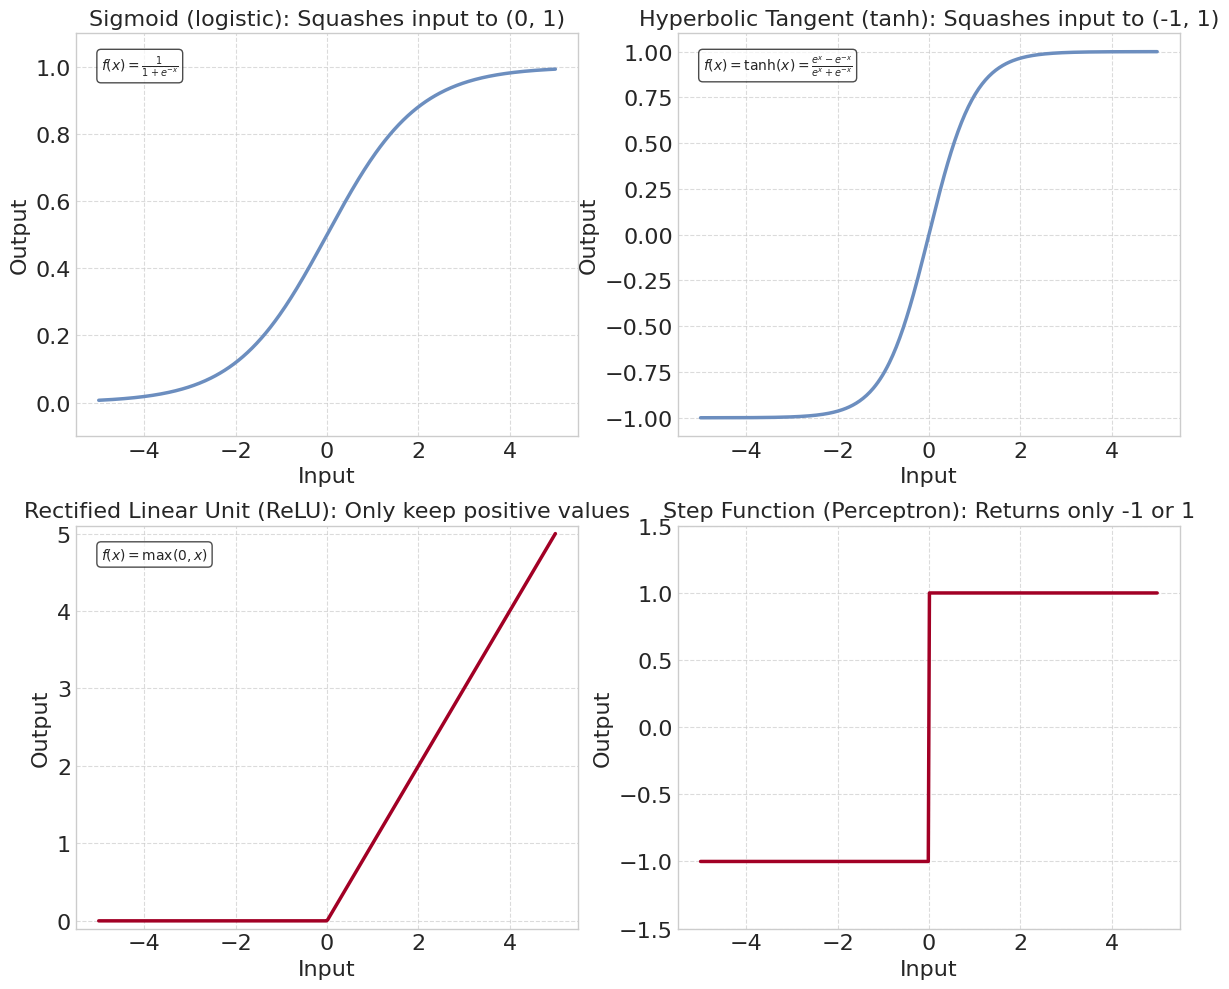

In [17]:
def visualize_activation_functions():
    """Visualize common neural network activation functions"""
    
    # Define the activation functions
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def tanh(x):
        return np.tanh(x)

    def relu(x):
        return np.maximum(0, x)

    def step_function(x):
        return np.where(x >= 0, 1, -1)

    # Generate input values
    x = np.linspace(-5, 5, 400)

    # Create figure and axes for 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot Sigmoid
    axs[0, 0].plot(x, sigmoid(x), label="Sigmoid", linewidth=2.5, color="#6C8EBF")
    axs[0, 0].set_title("Sigmoid (logistic): Squashes input to (0, 1)")
    axs[0, 0].set_ylim([-0.1, 1.1])
    axs[0, 0].text(0.05, 0.95, r'$f(x) = \frac{1}{1 + e^{-x}}$', 
                  transform=axs[0, 0].transAxes, 
                  verticalalignment='top', 
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Plot Tanh
    axs[0, 1].plot(x, tanh(x), label="Tanh", linewidth=2.5, color="#6C8EBF")
    axs[0, 1].set_title("Hyperbolic Tangent (tanh): Squashes input to (-1, 1)")
    axs[0, 1].set_ylim([-1.1, 1.1])
    axs[0, 1].text(0.05, 0.95, r'$f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$', 
                  transform=axs[0, 1].transAxes, 
                  verticalalignment='top', 
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Plot ReLU
    axs[1, 0].plot(x, relu(x), label="ReLU", linewidth=2.5, color="#A20025")
    axs[1, 0].set_title("Rectified Linear Unit (ReLU): Only keep positive values")
    axs[1, 0].set_ylim([-0.1, 5.1])
    axs[1, 0].text(0.05, 0.95, r'$f(x) = \max(0, x)$', 
                  transform=axs[1, 0].transAxes, 
                  verticalalignment='top', 
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Plot Step Function
    axs[1, 1].plot(x, step_function(x), label="Step Function", linewidth=2.5, color="#A20025")
    axs[1, 1].set_title("Step Function (Perceptron): Returns only -1 or 1")
    axs[1, 1].set_ylim([-1.5, 1.5])

    # Set a consistent label for x and y axes
    for ax in axs.flat:
        ax.set_xlabel("Input")
        ax.set_ylabel("Output")
        ax.grid(True, linestyle='--', alpha=0.7)

    # Save figure
    plt.tight_layout()
    plt.savefig(f'figures/{CHAPTER}/activation_functions.pdf', bbox_inches='tight', dpi=600)
    plt.savefig(f'figures/{CHAPTER}/activation_functions.png', bbox_inches='tight', dpi=600)
    
    return fig

# Visualize activation functions
activation_functions_fig = visualize_activation_functions()

### <b> <font color='#A20025'> Training the Neural Network Model

Now we'll train our neural network using the training data and evaluate its performance on the validation set during training:

2025-03-28 12:03:31,867 - INFO - Starting training for 50 epochs...
2025-03-28 12:03:34,522 - INFO - Epoch 1/50 - Train Loss: 3.6963, Val Loss: 0.9926
2025-03-28 12:03:36,853 - INFO - Epoch 2/50 - Train Loss: 1.0573, Val Loss: 0.8041
2025-03-28 12:03:39,308 - INFO - Epoch 3/50 - Train Loss: 0.8845, Val Loss: 1.0077
2025-03-28 12:03:42,357 - INFO - Epoch 4/50 - Train Loss: 0.8050, Val Loss: 0.7635
2025-03-28 12:03:45,585 - INFO - Epoch 5/50 - Train Loss: 0.6735, Val Loss: 0.7248
2025-03-28 12:03:48,170 - INFO - Epoch 6/50 - Train Loss: 0.6128, Val Loss: 0.8443
2025-03-28 12:03:51,237 - INFO - Epoch 7/50 - Train Loss: 0.5890, Val Loss: 0.8363
2025-03-28 12:03:54,788 - INFO - Epoch 8/50 - Train Loss: 0.5817, Val Loss: 0.7928
2025-03-28 12:03:57,254 - INFO - Epoch 9/50 - Train Loss: 0.5221, Val Loss: 0.7562
2025-03-28 12:03:59,735 - INFO - Epoch 10/50 - Train Loss: 0.4930, Val Loss: 0.7761
2025-03-28 12:04:02,392 - INFO - Epoch 11/50 - Train Loss: 0.5036, Val Loss: 0.7827
2025-03-28 12:04:

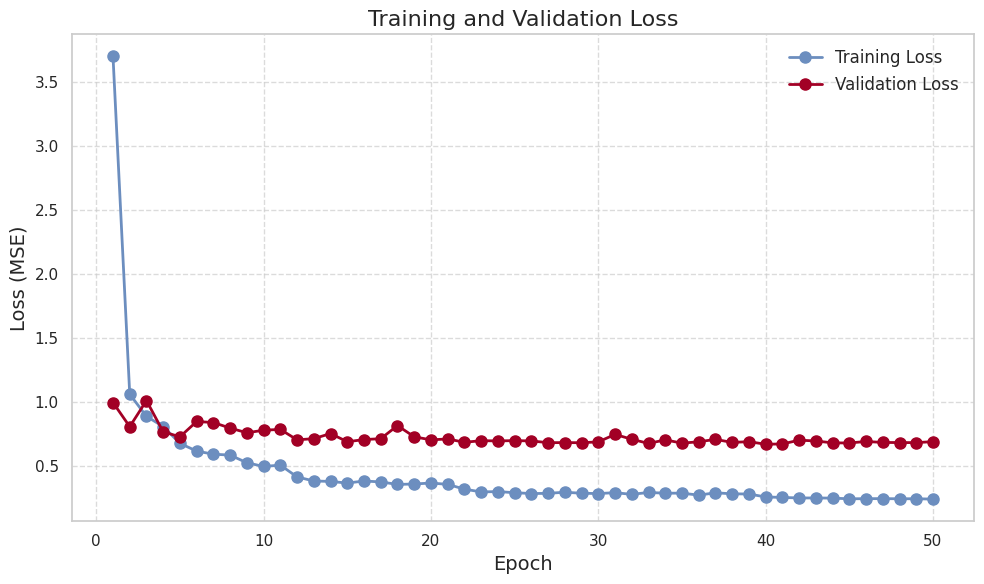

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50):
    """
    Train the neural network model.
    
    Parameters:
    -----------
    model : torch.nn.Module
        Neural network model
    train_loader : torch.utils.data.DataLoader
        DataLoader for training data
    val_loader : torch.utils.data.DataLoader
        DataLoader for validation data
    criterion : torch.nn.Module
        Loss function
    optimizer : torch.optim.Optimizer
        Optimization algorithm
    scheduler : torch.optim.lr_scheduler._LRScheduler
        Learning rate scheduler
    device : torch.device
        Device to train on (CPU or GPU)
    num_epochs : int
        Number of training epochs
        
    Returns:
    --------
    tuple
        (train_losses, val_losses) Lists of loss values during training
    """
    model.train()
    train_losses = []
    val_losses = []
    
    logger.info(f"Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average training loss
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():  # No gradients needed for validation
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        # Calculate average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Print progress
        logger.info(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    logger.info("Training complete")
    
    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, 'o-', label='Training Loss', linewidth=2, markersize=8, color="#6C8EBF")
    plt.plot(range(1, num_epochs+1), val_losses, 'o-', label='Validation Loss', linewidth=2, markersize=8, color="#A20025")
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss (MSE)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the loss curves
    plt.savefig(f'figures/{CHAPTER}/loss_curves.pdf', bbox_inches='tight', dpi=600)
    plt.savefig(f'figures/{CHAPTER}/loss_curves.png', bbox_inches='tight', dpi=600)
    
    return train_losses, val_losses

# Train the model if data loaders are available
train_losses, val_losses = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    device, 
    num_epochs=50
)


### <b> <font color='#A20025'> Evaluating the Model

Now let's evaluate our trained model on the test set. We'll create visualizations to assess model performance:

In [20]:
def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model on the test set.
    
    Parameters:
    -----------
    model : torch.nn.Module
        Trained neural network model
    test_loader : torch.utils.data.DataLoader
        DataLoader for test data
    criterion : torch.nn.Module
        Loss function
    device : torch.device
        Device to evaluate on (CPU or GPU)
        
    Returns:
    --------
    tuple
        (predictions, actuals, metrics) Model predictions, actual values, and evaluation metrics
    """
    model.eval()
    total_loss = 0.0
    predictions = []
    actuals = []
    
    # Evaluate without computing gradients
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Store predictions and actual values
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = np.corrcoef(predictions, actuals)[0, 1]**2
    
    # Log results
    logger.info(f'Test Loss: {total_loss/len(test_loader):.4f}')
    logger.info(f'Mean Squared Error: {mse:.4f}')
    logger.info(f'Root Mean Squared Error: {rmse:.4f}')
    logger.info(f'Mean Absolute Error: {mae:.4f}')
    logger.info(f'R-squared: {r2:.4f}')
    
    # Create a scatter plot of predictions vs actuals
    plt.figure(figsize=(10, 8))
    plt.scatter(actuals, predictions, alpha=0.7, s=50, color="#6C8EBF", edgecolor='w')
    
    # Add perfect prediction line
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--', color='#A20025', lw=2, 
             label='Perfect prediction')
    
    plt.xlabel('Actual Values', fontsize=14)
    plt.ylabel('Predicted Values', fontsize=14)
    plt.title('Test Set: Predicted vs Actual Values', fontsize=16)
    
    # Add metrics as text annotation
    plt.annotate(f"RMSE = {rmse:.3f}\nMAE = {mae:.3f}\nR² = {r2:.3f}",
                xy=(0.05, 0.95), xycoords='axes fraction',
                va='top', ha='left',
                bbox=dict(boxstyle='round', fc='white', alpha=0.8))
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'figures/{CHAPTER}/lbvs_scatter.pdf', bbox_inches='tight', dpi=600)
    plt.savefig(f'figures/{CHAPTER}/lbvs_scatter.png', bbox_inches='tight', dpi=600)
    
    # Compile metrics
    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    return predictions, actuals, metrics

2025-03-28 12:07:33,513 - INFO - Test Loss: 0.9511
2025-03-28 12:07:33,514 - INFO - Mean Squared Error: 0.9517
2025-03-28 12:07:33,515 - INFO - Root Mean Squared Error: 0.9755
2025-03-28 12:07:33,519 - INFO - Mean Absolute Error: 0.7395
2025-03-28 12:07:33,522 - INFO - R-squared: 0.5647
2025-03-28 12:07:39,825 - INFO - Model saved to artifacts/ch08/kinase_binder_model.pth


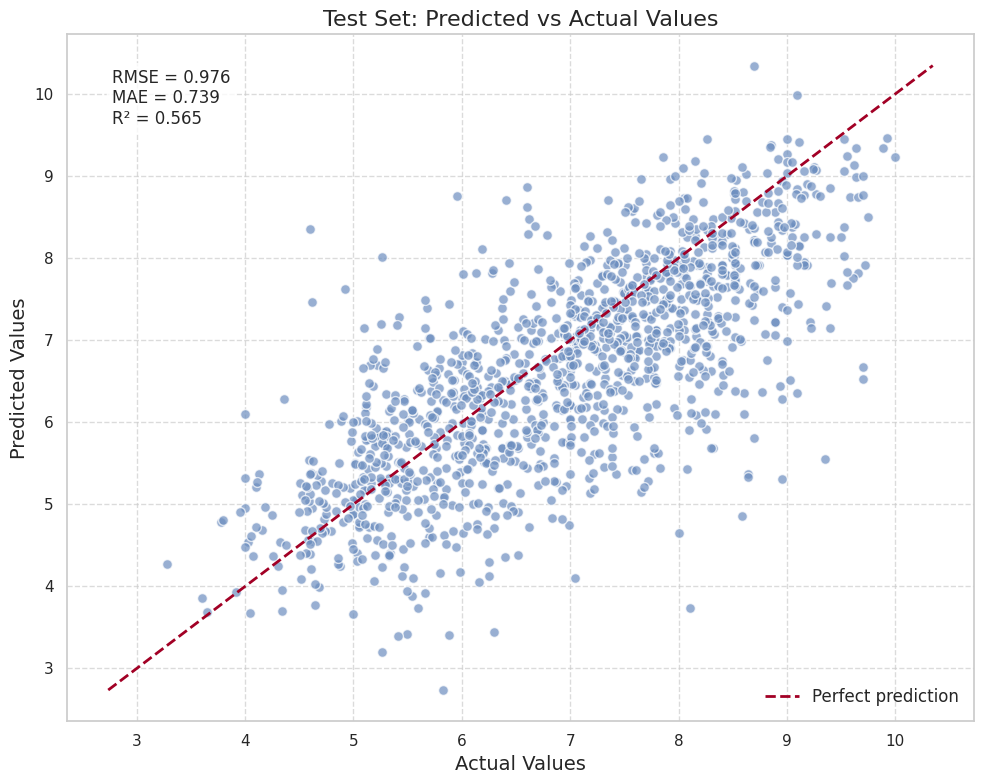

In [21]:
predictions, actuals, metrics = evaluate_model(model, test_loader, criterion, device)

# Save the trained model
torch.save(model.state_dict(), f'artifacts/{CHAPTER}/kinase_binder_model.pth')
logger.info(f"Model saved to artifacts/{CHAPTER}/kinase_binder_model.pth")

If we ever want to load our model elsewhere, it's as simple as the following:

In [22]:
loaded_model = KinaseBinderNN()
loaded_model.load_state_dict(torch.load('artifacts/ch08/kinase_binder_model.pth'))
loaded_model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_10600/1704290042.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('artifacts/ch08/kinase_binder_model.pth'))


KinaseBinderNN(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

### <b> <font color='#A20025'> Enrichment Factors in Virtual Screening

In virtual screening, we're interested in how well our model can identify active compounds early in the ranked list. This is crucial because in real-world drug discovery, we typically only experimentally test a small fraction of the virtual screening hits. Let's calculate enrichment factors and create an enrichment plot:

2025-03-28 12:16:12,122 - INFO - Enrichment Analysis:
2025-03-28 12:16:12,129 - INFO - Activity Threshold: 6.3
2025-03-28 12:16:12,131 - INFO - Actives: 849 (65.5%)
2025-03-28 12:16:12,133 - INFO - Inactives: 448 (34.5%)
2025-03-28 12:16:12,135 - INFO - Mean Squared Error: 0.9517
2025-03-28 12:16:12,136 - INFO - R-squared: 0.5647



Enrichment Factors:
--------------------------------------------------------------------------------
Selection % EF      Max EF  Hit Rate  Actives Found  Selected  
--------------------------------------------------------------------------------
EF0.5%      1.53    1.53    100.0%    6/849          6         
EF1.0%      1.53    1.53    100.0%    12/849         12        
EF2.0%      1.53    1.53    100.0%    25/849         25        
EF5.0%      1.50    1.53    98.4%     63/849         64        
EF10.0%     1.50    1.53    98.4%     127/849        129       
EF20.0%     1.48    1.53    96.9%     251/849        259       
EF50.0%     1.42    1.53    93.1%     603/849        648       


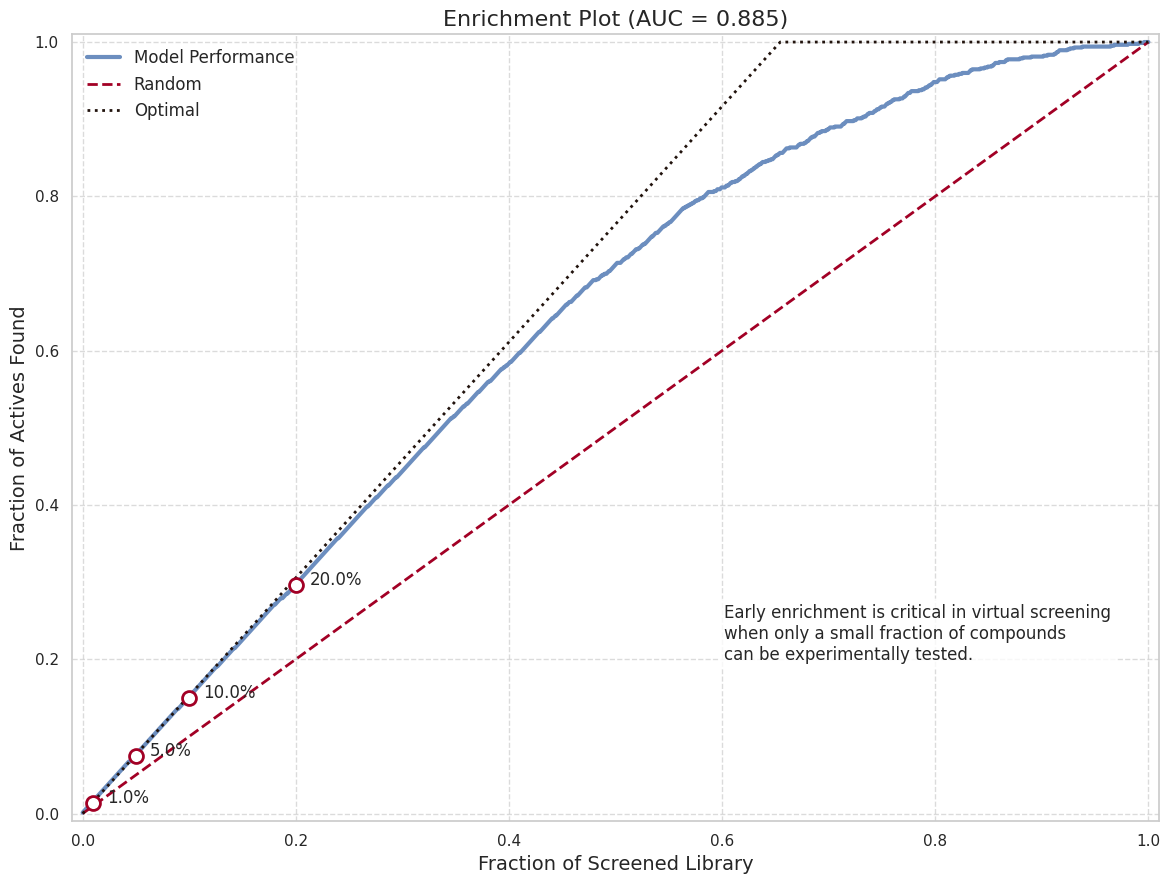

In [23]:
# %% [markdown]
# ### <b> <font color='#A20025'> Enrichment Analysis for Virtual Screening

# %% [markdown]
# In virtual screening, we're interested in how well our model can identify active compounds early in the ranked list. This is crucial because in real-world drug discovery, we typically only experimentally test a small fraction of the virtual screening hits. Let's calculate enrichment factors and create an enrichment plot:

# %%
def evaluate_model_enrichment(model, test_loader, activity_threshold=6.3):
    """
    Evaluate model for enrichment analysis in virtual screening.
    
    Parameters:
    -----------
    model : torch.nn.Module
        Trained neural network model
    test_loader : torch.utils.data.DataLoader
        DataLoader for test data
    activity_threshold : float
        Threshold for considering a compound active
        
    Returns:
    --------
    tuple
        (predictions, actuals) Model predictions and actual values
    """
    # Get predictions using the model
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    # Log basic stats about the model's performance
    mse = mean_squared_error(actuals, predictions)
    r2 = np.corrcoef(predictions, actuals)[0, 1]**2
    
    # Count actives/inactives based on threshold
    n_actives = sum(actuals >= activity_threshold)
    n_inactives = sum(actuals < activity_threshold)
    
    logger.info(f'Enrichment Analysis:')
    logger.info(f'Activity Threshold: {activity_threshold}')
    logger.info(f'Actives: {n_actives} ({n_actives/(n_actives+n_inactives)*100:.1f}%)')
    logger.info(f'Inactives: {n_inactives} ({n_inactives/(n_actives+n_inactives)*100:.1f}%)')
    logger.info(f'Mean Squared Error: {mse:.4f}')
    logger.info(f'R-squared: {r2:.4f}')

    return predictions, actuals

def calculate_enrichment_factors(y_true, y_pred, activity_threshold=6.3, ef_percentages=[0.005, 0.01, 0.02, 0.05]):
    """
    Calculate enrichment factors for various percentages of the ranked database.
    
    Parameters:
    -----------
    y_true : numpy.ndarray
        True activity values
    y_pred : numpy.ndarray
        Predicted activity values
    activity_threshold : float
        Threshold for considering a compound active
    ef_percentages : list
        List of percentages at which to calculate enrichment factors
        
    Returns:
    --------
    dict
        Dictionary containing enrichment factors at each percentage
    """
    # Convert continuous activities to binary (active/inactive)
    y_true_binary = (y_true >= activity_threshold).astype(int)
    
    # Rank compounds by predicted activity (descending)
    sorted_indices = np.argsort(y_pred)[::-1]
    
    # Calculate total number of actives and compounds
    n_actives = np.sum(y_true_binary)
    n_total = len(y_true_binary)
    
    # Calculate random hit rate (baseline)
    random_hit_rate = n_actives / n_total
    
    # Calculate enrichment factors
    enrichment_factors = {}
    
    for percentage in ef_percentages:
        # Number of compounds to select
        n_compounds = int(n_total * percentage)
        
        # Number of actives found in top n_compounds
        n_actives_found = np.sum(y_true_binary[sorted_indices[:n_compounds]])
        
        # Actual hit rate in the top n_compounds
        actual_hit_rate = n_actives_found / n_compounds if n_compounds > 0 else 0
        
        # Enrichment factor = actual hit rate / random hit rate
        ef = actual_hit_rate / random_hit_rate if random_hit_rate > 0 else 0
        
        # Maximum possible enrichment factor
        max_ef = min(1 / percentage, n_total / n_actives) if n_actives > 0 else 0
        
        # Store results
        enrichment_factors[f"EF{percentage*100:.1f}%"] = {
            "Model": ef,
            "Optimal": max_ef,
            "Random": 1.0,  # By definition
            "Actives Found": n_actives_found,
            "Selected Compounds": n_compounds,
            "Hit Rate": f"{actual_hit_rate*100:.1f}%"
        }
    
    return enrichment_factors

def create_enrichment_plot(y_true, y_pred, activity_threshold=6.3, ef_percentages=[0.01, 0.05, 0.1]):
    """
    Create an enrichment plot for virtual screening.
    
    Parameters:
    -----------
    y_true : numpy.ndarray
        True activity values
    y_pred : numpy.ndarray
        Predicted activity values
    activity_threshold : float
        Threshold for considering a compound active
    ef_percentages : list
        List of percentages at which to highlight enrichment
        
    Returns:
    --------
    matplotlib.figure.Figure
        Enrichment plot
    """
    # Convert to binary
    y_true_binary = (y_true >= activity_threshold).astype(int)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Calculate enrichment curve
    sorted_indices = np.argsort(y_pred)[::-1]
    n_actives = np.sum(y_true_binary)
    n_total = len(y_true_binary)
    
    # Calculate fraction of screened library vs fraction of actives found
    x_values = np.linspace(0, 1, n_total)
    y_values = np.cumsum(y_true_binary[sorted_indices]) / n_actives
    
    # Set up the plot style
    plt.figure(figsize=(12, 9))
    
    # Plot enrichment curve
    plt.plot(x_values, y_values, label='Model Performance', 
             linewidth=3, color="#6C8EBF")
    plt.plot([0, 1], [0, 1], label='Random', 
             linestyle='--', linewidth=2, color="#A20025")
    
    # Plot optimal curve (all actives at top)
    x_optimal = [0, n_actives/n_total, 1]
    y_optimal = [0, 1, 1]
    plt.plot(x_optimal, y_optimal, label='Optimal', 
             linestyle=':', linewidth=2, color="#21130d")
    
    # Add markers for EF percentages
    for percentage in ef_percentages:
        index = int(n_total * percentage) - 1
        if index >= 0 and index < len(y_values):
            plt.plot(percentage, y_values[index], 'o', markersize=10, 
                     markerfacecolor='white', markeredgecolor='#A20025', 
                     markeredgewidth=2)
            plt.annotate(f'{percentage*100:.1f}%', 
                         (percentage, y_values[index]), 
                         xytext=(10, 0), textcoords='offset points', 
                         fontsize=12)
    
    # Customize the plot
    plt.xlabel('Fraction of Screened Library', fontsize=14)
    plt.ylabel('Fraction of Actives Found', fontsize=14)
    plt.title(f'Enrichment Plot (AUC = {roc_auc:.3f})', fontsize=16)
    plt.legend(fontsize=12)
    
    # Add annotation about early enrichment
    plt.annotate(
        f"Early enrichment is critical in virtual screening\nwhen only a small fraction of compounds\ncan be experimentally tested.",
        xy=(0.6, 0.2), 
        xycoords='axes fraction',
        ha='left',
        va='bottom',
        bbox=dict(boxstyle='round', fc='white', alpha=0.8)
    )
    
    # Adjust plot limits and ticks
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(f'figures/{CHAPTER}/enrichment_plot.png', bbox_inches='tight', dpi=600)
    plt.savefig(f'figures/{CHAPTER}/enrichment_plot.pdf', bbox_inches='tight', dpi=600)
    
    return plt.gcf()

# Ensure model is loaded and in evaluation mode
try:
    if not isinstance(model, KinaseBinderNN):
        model = KinaseBinderNN().to(device)
        try:
            model.load_state_dict(torch.load(f'artifacts/{CHAPTER}/kinase_binder_model.pth'))
            logger.info(f"Loaded model from artifacts/{CHAPTER}/kinase_binder_model.pth")
        except:
            logger.warning("Could not load saved model. Using current model.")
    model.eval()
    
    # Get predictions for enrichment analysis
    predictions, actuals = evaluate_model_enrichment(model, test_loader)
    
    # Calculate enrichment factors
    ef_percentages = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
    enrichment_factors = calculate_enrichment_factors(
        actuals, predictions, 
        activity_threshold=6.3, 
        ef_percentages=ef_percentages
    )
    
    # Display enrichment factors in a more readable format
    print("\nEnrichment Factors:")
    print("-" * 80)
    print(f"{'Selection %':<12}{'EF':<8}{'Max EF':<8}{'Hit Rate':<10}{'Actives Found':<15}{'Selected':<10}")
    print("-" * 80)
    
    for k, v in enrichment_factors.items():
        percentage = k
        ef = v['Model']
        max_ef = v['Optimal']
        hit_rate = v['Hit Rate']
        actives = f"{v['Actives Found']}/{sum(actuals >= 6.3)}"
        selected = v['Selected Compounds']
        
        print(f"{percentage:<12}{ef:<8.2f}{max_ef:<8.2f}{hit_rate:<10}{actives:<15}{selected:<10}")
    
    # Create enrichment plot
    enrichment_plot = create_enrichment_plot(
        actuals, predictions, 
        activity_threshold=6.3, 
        ef_percentages=[0.01, 0.05, 0.1, 0.2]
    )
except Exception as e:
    logger.error(f"Error during enrichment analysis: {str(e)}")
    import traceback
    traceback.print_exc()

## <b> <font color='#A20025'> 2️⃣ Neural Networks & PyTorch Mechanics

*Companion code for this section of the book is already referenced within the earlier parts of this notebook.*

The previous sections already introduced several key PyTorch mechanics including:
 
1. **Tensor operations** - The fundamental data structure in PyTorch
2. **Dataset and DataLoader creation** - For efficient data handling during training
3. **Model definition** - Creating a neural network using Module and layers
4. **Training loop** - Forward/backward passes and optimization
5. **Evaluation** - Assessing model performance

Here's a quick reference of the PyTorch pipeline we've implemented

In [26]:
def pytorch_neural_network_pipeline_summary():
    """Display a summary of the PyTorch neural network pipeline steps"""
    
    pipeline = {
        "1. Data Preparation": {
            "Convert SMILES to Fingerprints": "smiles_to_fingerprint()",
            "Create Custom Dataset": "MoleculeDataset class",
            "Create DataLoaders": "DataLoader with batching and shuffling"
        },
        "2. Model Definition": {
            "Define Network Architecture": "KinaseBinderNN class with layers",
            "Initialize Model": "model = KinaseBinderNN().to(device)",
            "Define Loss Function": "criterion = nn.MSELoss()",
            "Choose Optimizer": "optimizer = optim.Adam(model.parameters(), lr=0.001)"
        },
        "3. Training Loop": {
            "For each epoch:": {
                "Training phase": [
                    "model.train()",
                    "For each batch:",
                    "  Forward pass: outputs = model(inputs)",
                    "  Calculate loss: loss = criterion(outputs, targets)",
                    "  Backward pass: loss.backward()",
                    "  Update weights: optimizer.step()"
                ],
                "Validation phase": [
                    "model.eval()",
                    "with torch.no_grad():",
                    "  For each batch:",
                    "    Forward pass: outputs = model(inputs)",
                    "    Calculate loss: loss = criterion(outputs, targets)"
                ],
                "Update learning rate": "scheduler.step(val_loss)"
            }
        },
        "4. Evaluation": {
            "Test set performance": "mean_squared_error, r-squared",
            "Virtual screening metrics": "Enrichment factors, ROC AUC"
        },
        "5. Model Persistence": {
            "Save model": "torch.save(model.state_dict(), 'model.pth')",
            "Load model": "model.load_state_dict(torch.load('model.pth'))"
        }
    }
    
    # Display the pipeline as formatted text
    import json
    print(json.dumps(pipeline, indent=2))
    
    return pipeline

# Show the pipeline summary
pytorch_neural_network_pipeline_summary();

{
  "1. Data Preparation": {
    "Convert SMILES to Fingerprints": "smiles_to_fingerprint()",
    "Create Custom Dataset": "MoleculeDataset class",
    "Create DataLoaders": "DataLoader with batching and shuffling"
  },
  "2. Model Definition": {
    "Define Network Architecture": "KinaseBinderNN class with layers",
    "Initialize Model": "model = KinaseBinderNN().to(device)",
    "Define Loss Function": "criterion = nn.MSELoss()",
    "Choose Optimizer": "optimizer = optim.Adam(model.parameters(), lr=0.001)"
  },
  "3. Training Loop": {
    "For each epoch:": {
      "Training phase": [
        "model.train()",
        "For each batch:",
        "  Forward pass: outputs = model(inputs)",
        "  Calculate loss: loss = criterion(outputs, targets)",
        "  Backward pass: loss.backward()",
        "  Update weights: optimizer.step()"
      ],
      "Validation phase": [
        "model.eval()",
        "with torch.no_grad():",
        "  For each batch:",
        "    Forward pass

The remaining portions of this chapter contain additional details about these concepts and deeper explanations of the underlying theory. Refer to the chapter text for comprehensive explanations of neural network principles including:
 
- Backpropagation algorithm
- Gradient descent optimization
- Regularization techniques
- Hyperparameter tuning strategies
- Model interpretability approaches
- Best practices for deep learning in drug discovery

## <b> <font color='#A20025'> Summary

In this notebook, we've explored:
 
1. **PyTorch basics** - Tensors, operations, and neural network building blocks
2. **Deep learning for ligand-based VS** - A complete pipeline for predicting kinase binding activities
3. **Model evaluation** - Assessing model performance for drug discovery applications
4. **Enrichment analysis** - Techniques for evaluating virtual screening effectiveness
 
The techniques demonstrated here form the foundation for more advanced deep learning approaches in drug discovery that we'll explore in subsequent chapters.


## <b> <font color='#A20025'> Interactive Exploration

As you progress through the book, consider experimenting with the code above by:
 
1. Modifying the neural network architecture (e.g., changing layer sizes, adding more layers)
2. Trying different molecular representations (e.g., MACCS keys, topological fingerprints)
3. Applying different regularization techniques (e.g., batch normalization, weight decay)
4. Testing alternative activation functions (e.g., LeakyReLU, SELU)
5. Implementing more sophisticated model interpretability approaches
 
*See the book for more exercises.*

## <b> <font color='#A20025'> References

[1] https://www.manning.com/books/deep-learning-with-pytorch-second-edition

[2] Roskoski, R. Properties of FDA-Approved Small Molecule Protein Kinase Inhibitors: A 2024 Update. Pharmacol. Res. 2024, 200, 107059. https://doi.org/10.1016/j.phrs.2024.107059

[3] G. Manning et al. ,The Protein Kinase Complement of the Human Genome. Science 298, 1912-1934 (2002). DOI:10.1126/science.1075762